### **GTZAN Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import IPython.display as ipd
from scipy.io import wavfile as wav
import pandas as pd
import os
import numpy as np
import seaborn as sns
import scipy

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [ ]:
#!unzip "/content/drive/MyDrive/archive.zip" -d "/content/drive/MyDrive/"

In [ ]:
def plot_sound(path):
    plt.figure(figsize=(14, 5))
    x, sr = librosa.load(path)
    print("length {}, sample-rate {}".format(x.shape, sr))
    librosa.display.waveplot(x, sr=sr)
    
    return x

length (661794,), sample-rate 22050


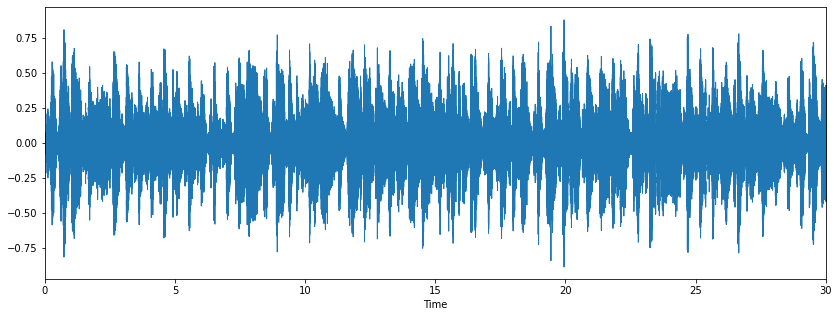

In [ ]:
blues_path = '/content/drive/MyDrive/Data/genres_original/blues/blues.00000.wav'
blues_audio = plot_sound(blues_path)
ipd.Audio(blues_path)

length (661794,), sample-rate 22050


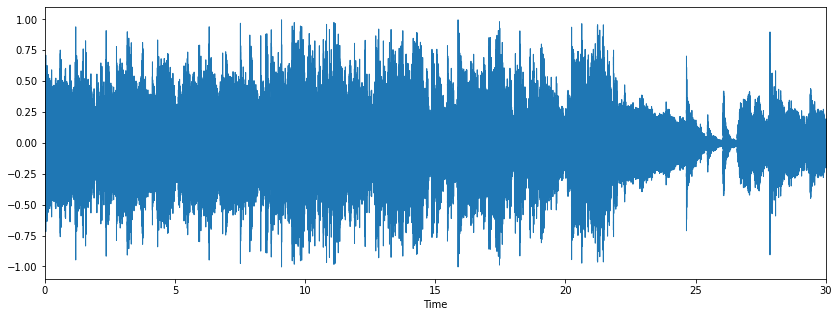

In [ ]:
rock_path = '/content/drive/MyDrive/Data/genres_original/rock/rock.00001.wav'
rock_audio = plot_sound(rock_path)
ipd.Audio(rock_path)

### **Spectrogram**

In [ ]:
x, sr = librosa.load(rock_path)

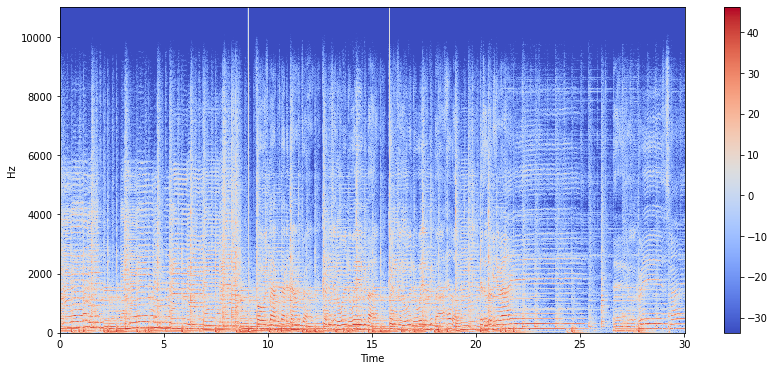

In [ ]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 6))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()

### **Dataset**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data/features_3_sec.csv')
df.head()

filename  length  chroma_stft_mean  ...  mfcc20_mean  mfcc20_var  label
0  blues.00000.0.wav   66149          0.335406  ...    -0.243027   43.771767  blues
1  blues.00000.1.wav   66149          0.343065  ...     5.784063   59.943081  blues
2  blues.00000.2.wav   66149          0.346815  ...     2.517375   33.105122  blues
3  blues.00000.3.wav   66149          0.363639  ...     3.630866   32.023678  blues
4  blues.00000.4.wav   66149          0.335579  ...     0.536961   29.146694  blues

[5 rows x 60 columns]

In [ ]:
df.shape

(9990, 60)

In [ ]:
df['label'].value_counts()

blues        1000
jazz         1000
reggae       1000
pop          1000
metal        1000
disco         999
rock          998
classical     998
hiphop        998
country       997
Name: label, dtype: int64

In [ ]:
df.columns

Index(['filename', 'length', 'chroma_stft_mean', 'chroma_stft_var', 'rms_mean',
       'rms_var', 'spectral_centroid_mean', 'spectral_centroid_var',
       'spectral_bandwidth_mean', 'spectral_bandwidth_var', 'rolloff_mean',
       'rolloff_var', 'zero_crossing_rate_mean', 'zero_crossing_rate_var',
       'harmony_mean', 'harmony_var', 'perceptr_mean', 'perceptr_var', 'tempo',
       'mfcc1_mean', 'mfcc1_var', 'mfcc2_mean', 'mfcc2_var', 'mfcc3_mean',
       'mfcc3_var', 'mfcc4_mean', 'mfcc4_var', 'mfcc5_mean', 'mfcc5_var',
       'mfcc6_mean', 'mfcc6_var', 'mfcc7_mean', 'mfcc7_var', 'mfcc8_mean',
       'mfcc8_var', 'mfcc9_mean', 'mfcc9_var', 'mfcc10_mean', 'mfcc10_var',
       'mfcc11_mean', 'mfcc11_var', 'mfcc12_mean', 'mfcc12_var', 'mfcc13_mean',
       'mfcc13_var', 'mfcc14_mean', 'mfcc14_var', 'mfcc15_mean', 'mfcc15_var',
       'mfcc16_mean', 'mfcc16_var', 'mfcc17_mean', 'mfcc17_var', 'mfcc18_mean',
       'mfcc18_var', 'mfcc19_mean', 'mfcc19_var', 'mfcc20_mean', 'mfcc20_var',
  

### **Feature Correlation Heatmap**

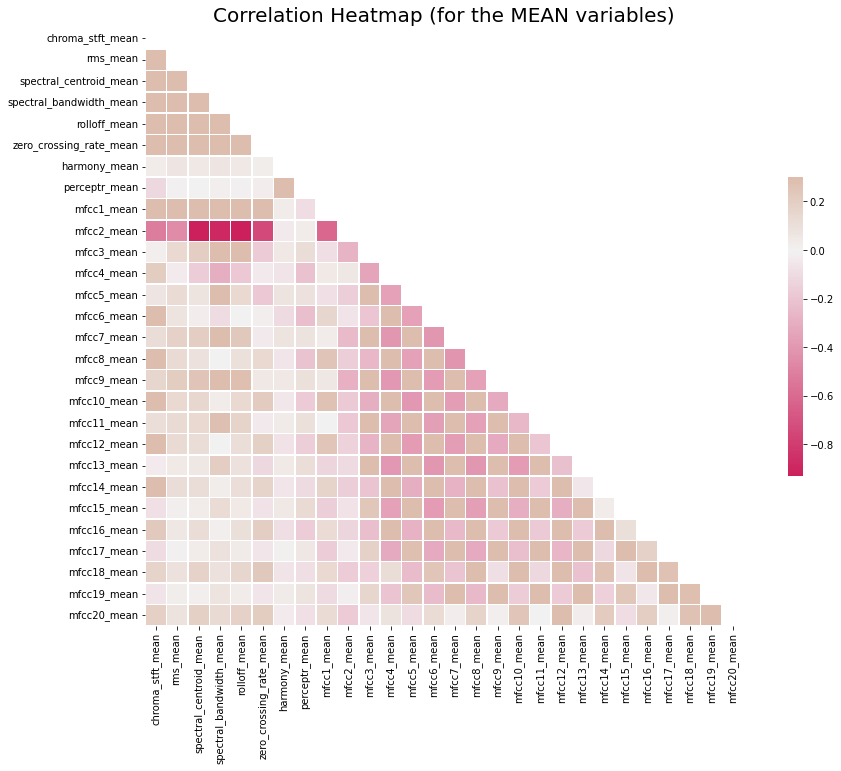

In [ ]:
# Computing the Correlation Matrix
spike_cols = [col for col in df.columns if 'mean' in col]
corr = df[spike_cols].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(16, 11));

# Generate a custom diverging colormap
cmap = sns.diverging_palette(0, 25, as_cmap=True, s = 90, l = 45, n = 5)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Correlation Heatmap (for the MEAN variables)', fontsize = 20)
plt.xticks(fontsize = 10)
plt.yticks(fontsize = 10);

### **Genre Distribution Box Plot**

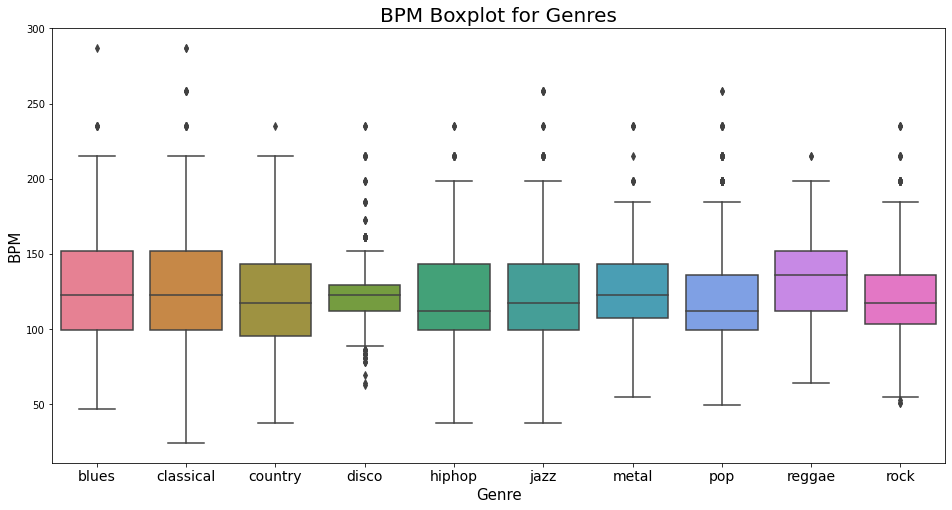

In [ ]:
x = df[["label", "tempo"]]

fig, ax = plt.subplots(figsize=(16, 8));
sns.boxplot(x = "label", y = "tempo", data = x, palette = 'husl');

plt.title('BPM Boxplot for Genres', fontsize = 20)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 10);
plt.xlabel("Genre", fontsize = 15)
plt.ylabel("BPM", fontsize = 15)
plt.savefig("BPM_Boxplot.png")

### **Data Processing**

In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])

In [ ]:
X = df.drop(['label','filename'],axis=1)
y = df['label'] 

In [ ]:
cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns = cols)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=111)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6993, 58), (2997, 58), (6993,), (2997,))

In [ ]:
def model_assess(model, title = "Default"):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    #print(confusion_matrix(y_test, preds))
    print('Accuracy', title, ':', round(accuracy_score(y_test, preds), 5), '\n')

In [ ]:
# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Logistic Regression")

Accuracy Naive Bayes : 0.51518 

Accuracy Stochastic Gradient Descent : 0.668 

Accuracy KNN : 0.80414 

Accuracy Decission trees : 0.65933 

Accuracy Random Forest : 0.80814 

Accuracy Support Vector Machine : 0.74775 

Accuracy Logistic Regression : 0.68402 



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
ndf = pd.read_csv('/content/drive/MyDrive/Data/features_30_sec.csv')
label_encoder = preprocessing.LabelEncoder()
ndf['label'] = label_encoder.fit_transform(ndf['label'])

X = ndf.drop(['label','filename'],axis=1)
y = ndf['label'] 

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns = cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=111)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Logistic Regression")

Accuracy Naive Bayes : 0.56333 

Accuracy Stochastic Gradient Descent : 0.67 

Accuracy KNN : 0.61667 

Accuracy Decission trees : 0.59333 

Accuracy Random Forest : 0.78 

Accuracy Support Vector Machine : 0.71333 

Accuracy Logistic Regression : 0.67 



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


# **Feature Engineering**

In [ ]:
wave_sample_rate, wave_audio = wav.read(rock_path)
print('Audio Sampling Rate: '+str(wave_sample_rate)+' samples/sec')

Audio Sampling Rate: 22050 samples/sec


To determine the music genre of a music piece, a number of content-based features are first extracted. In general, the features employed for music classification can be roughly categorized into three classes: timbral texture, rhythmic features, and pitch content features.


Timbral features are generally characterized by the properties related to instrumentations or sound sources such as music, speech, or environment signals. The features used to represent the timbral texture of a music track include zero crossing, spectral centroid, spectral flux, spectral rolloff, Mel-frequency cepstral coefficients (MFCC), Daubechies wavelet coefficients histograms (DWCH), and octave-based spectral contrast (OSC), etc.

Rhythmic features provide the main beat and its strength of a music track. Several beat-tracking algorithms have been proposed to estimate the main beat and the corresponding strength. 

 Pitch features, mainly derived from the pitch histogram, describe the melody of the music.

**Separation of harmonic and percussive**

Text(0.5, 1.0, 'Harmonic + Percussive')

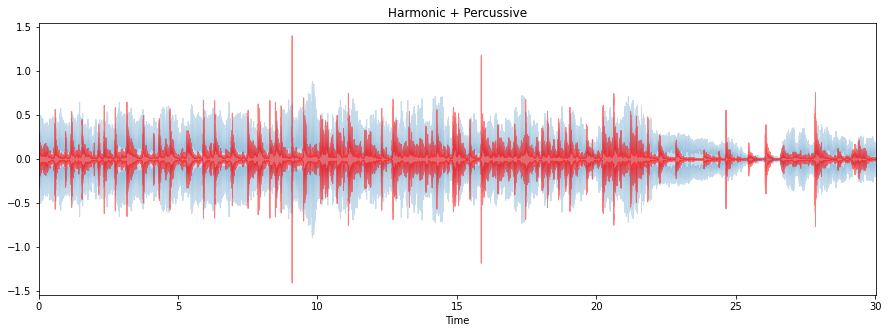

In [ ]:
y, sr = librosa.load(rock_path)
y_harmonic, y_percussive = librosa.effects.hpss(y)
plt.figure(figsize=(15, 5))
librosa.display.waveplot(y_harmonic, sr=sr, alpha=0.25)
librosa.display.waveplot(y_percussive, sr=sr, color='r', alpha=0.5)
plt.title('Harmonic + Percussive')

**1. Beat Extraction**

Detected Tempo: 135.99917763157896 beats/min


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


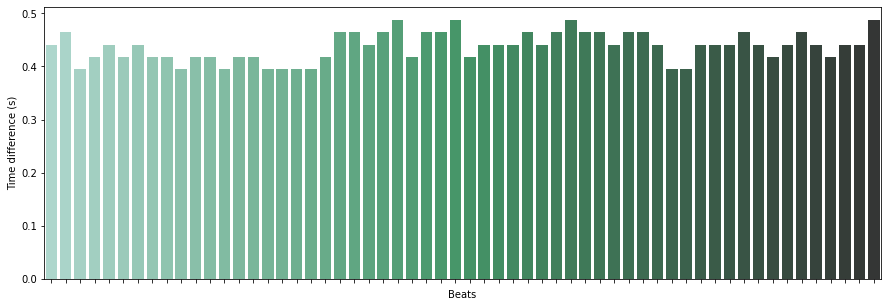

In [ ]:
tempo, beat_frames = librosa.beat.beat_track(y=y_harmonic, sr=sr)
print('Detected Tempo: '+str(tempo)+ ' beats/min')
beat_times = librosa.frames_to_time(beat_frames, sr=sr)
beat_time_diff=np.ediff1d(beat_times)
beat_nums = np.arange(1, np.size(beat_times))

fig, ax = plt.subplots()
fig.set_size_inches(15, 5)
ax.set_ylabel("Time difference (s)")
ax.set_xlabel("Beats")
g=sns.barplot(beat_nums, beat_time_diff, palette="BuGn_d",ax=ax)
g=g.set(xticklabels=[])

**2. Chroma Energy Normalized (CENS)**

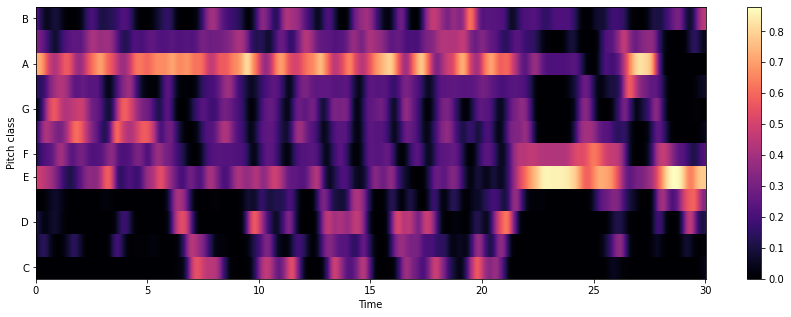

In [ ]:
chroma=librosa.feature.chroma_cens(y=y_harmonic, sr=sr)
plt.figure(figsize=(15, 5))
librosa.display.specshow(chroma,y_axis='chroma', x_axis='time')
plt.colorbar()

**3. Calculate MFCCs**

Text(0.5, 1.0, 'MFCC')

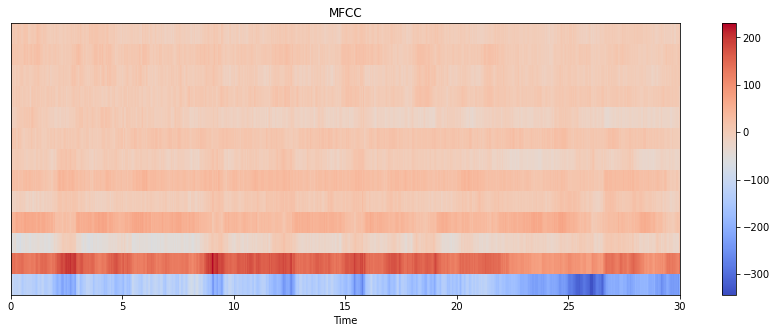

In [ ]:
mfccs = librosa.feature.mfcc(y=y_harmonic, sr=sr, n_mfcc=13)
plt.figure(figsize=(15, 5))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')

**4. Spectral Centroid**

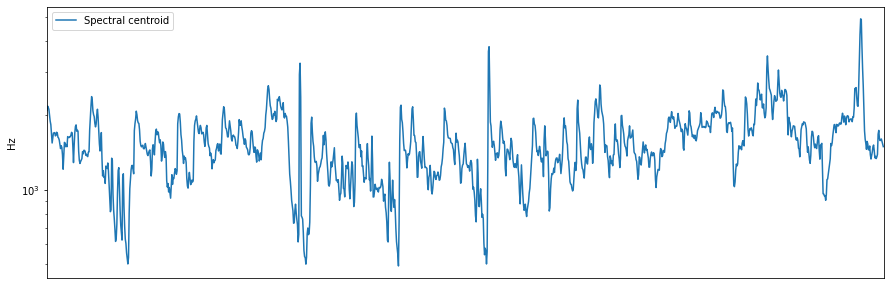

In [ ]:
cent = librosa.feature.spectral_centroid(y=y, sr=sr)
plt.figure(figsize=(15,5))
plt.subplot(1, 1, 1)
plt.semilogy(cent.T, label='Spectral centroid')
plt.ylabel('Hz')
plt.xticks([])
plt.xlim([0, cent.shape[-1]])
plt.legend()

**5. Spectral Contrast**

Text(0.5, 1.0, 'Spectral contrast')

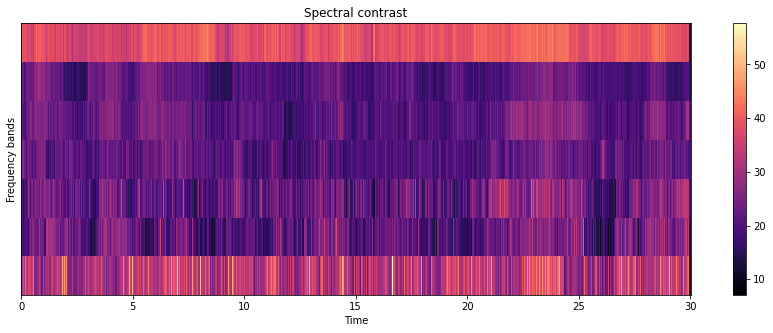

In [ ]:
contrast=librosa.feature.spectral_contrast(y=y_harmonic,sr=sr)
plt.figure(figsize=(15,5))
librosa.display.specshow(contrast, x_axis='time')
plt.colorbar()
plt.ylabel('Frequency bands')
plt.title('Spectral contrast')

**6. Spectral Rolloff**

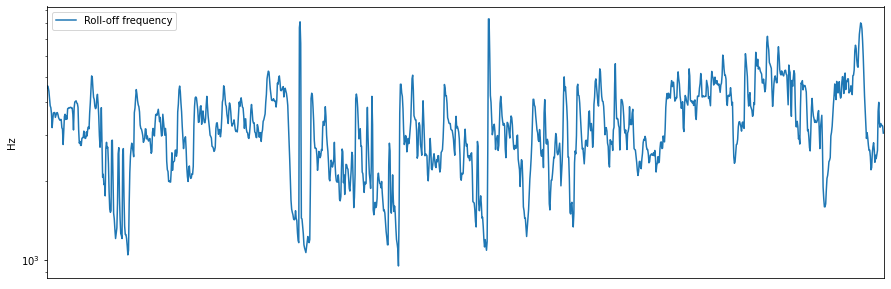

In [ ]:
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
plt.figure(figsize=(15,5))
plt.semilogy(rolloff.T, label='Roll-off frequency')
plt.ylabel('Hz')
plt.xticks([])
plt.xlim([0, rolloff.shape[-1]])
plt.legend()

**7. Zero Crossing Rate**

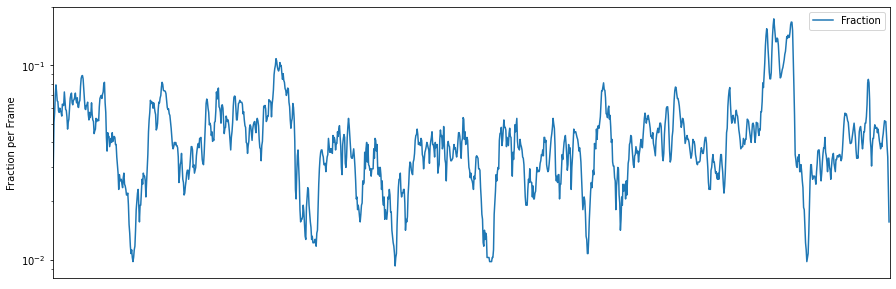

In [ ]:
zrate=librosa.feature.zero_crossing_rate(y_harmonic)
plt.figure(figsize=(15,5))
plt.semilogy(zrate.T, label='Fraction')
plt.ylabel('Fraction per Frame')
plt.xticks([])
plt.xlim([0, rolloff.shape[-1]])
plt.legend()

### **Feature Generation**

**1. Chroma Energy Normalized**

chroma_mean_0  chroma_mean_1  ...  chroma_std_10  chroma_std_11
0       0.127263       0.105325  ...       0.119996       0.128222

[1 rows x 24 columns]

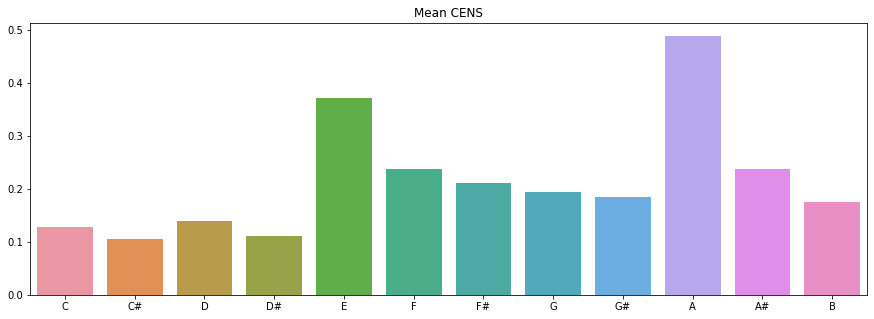

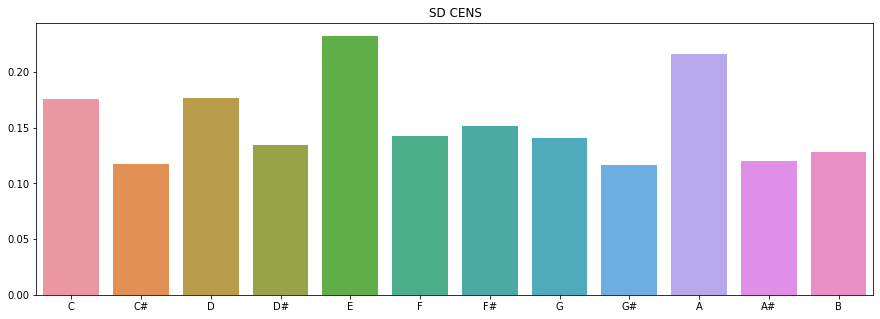

In [ ]:
chroma_mean=np.mean(chroma,axis=1)
chroma_std=np.std(chroma,axis=1)
#plot the summary
octave=['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
plt.figure(figsize=(15,5))
plt.title('Mean CENS')
sns.barplot(x=octave,y=chroma_mean)

plt.figure(figsize=(15,5))
plt.title('SD CENS')
sns.barplot(x=octave,y=chroma_std)
#Generate the chroma Dataframe
chroma_df=pd.DataFrame()
for i in range(0,12):
    chroma_df['chroma_mean_'+str(i)]=chroma_mean[i]
for i in range(0,12):
    chroma_df['chroma_std_'+str(i)]=chroma_mean[i]
chroma_df.loc[0]=np.concatenate((chroma_mean,chroma_std),axis=0)

chroma_df

**2. MFCCs**

mfccs_mean_0  mfccs_mean_1  ...  mfccs_std_11  mfccs_std_12
0    -170.71936    138.968491  ...      8.001941       7.09394

[1 rows x 26 columns]

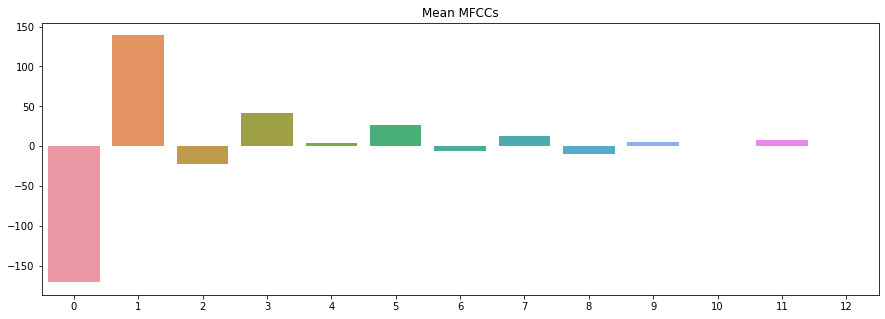

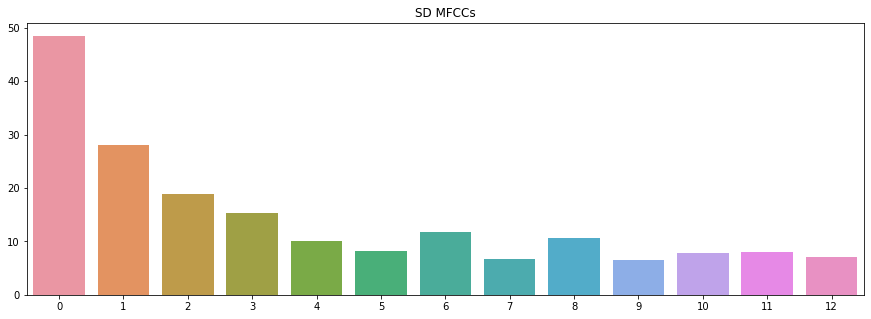

In [ ]:
mfccs_mean=np.mean(mfccs,axis=1)
mfccs_std=np.std(mfccs,axis=1)

coeffs=np.arange(0,13)
plt.figure(figsize=(15,5))
plt.title('Mean MFCCs')
sns.barplot(x=coeffs,y=mfccs_mean)

plt.figure(figsize=(15,5))
plt.title('SD MFCCs')
sns.barplot(x=coeffs,y=mfccs_std)
#Generate the chroma Dataframe
mfccs_df=pd.DataFrame()
for i in range(0,13):
    mfccs_df['mfccs_mean_'+str(i)]=mfccs_mean[i]
for i in range(0,13):
    mfccs_df['mfccs_std_'+str(i)]=mfccs_mean[i]
mfccs_df.loc[0]=np.concatenate((mfccs_mean,mfccs_std),axis=0)
mfccs_df

**3. Spectral Features**

In [ ]:
import scipy
cent_mean=np.mean(cent)
cent_std=np.std(cent)
cent_skew=scipy.stats.skew(cent,axis=1)[0]
print('Mean: '+str(cent_mean))
print('SD: '+str(cent_std))
print('Skewness: '+str(cent_skew))

Mean: 1529.474960625274
SD: 476.4199627349647
Skewness: 1.2218186189112656


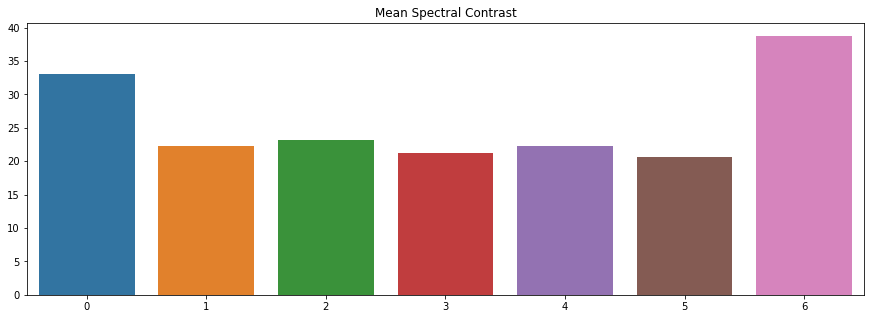

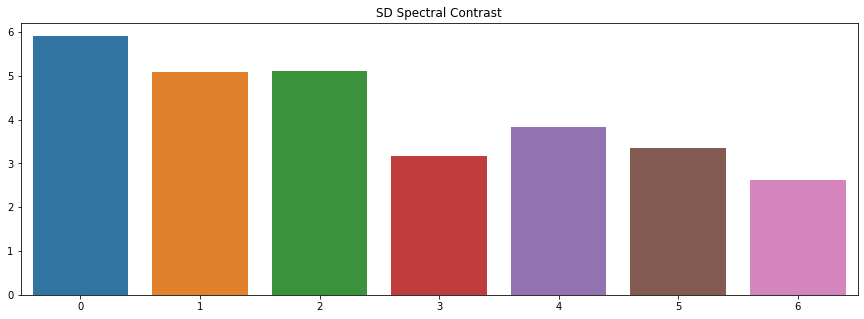

In [ ]:
contrast_mean=np.mean(contrast,axis=1)
contrast_std=np.std(contrast,axis=1)

conts=np.arange(0,7)
plt.figure(figsize=(15,5))
plt.title('Mean Spectral Contrast')
sns.barplot(x=conts,y=contrast_mean)

plt.figure(figsize=(15,5))
plt.title('SD Spectral Contrast')
sns.barplot(x=conts,y=contrast_std)
#Generate the chroma Dataframe
contrast_df=pd.DataFrame()

In [ ]:
rolloff_mean=np.mean(rolloff)
rolloff_std=np.std(rolloff)
rolloff_skew=scipy.stats.skew(rolloff,axis=1)[0]
print('Mean: '+str(rolloff_mean))
print('SD: '+str(rolloff_std))
print('Skewness: '+str(rolloff_skew))
Mean: 1667.91619566
SD: 1766.92961628
Skewness: 1.78492806278
spectral_df=pd.DataFrame()
collist=['cent_mean','cent_std','cent_skew']
for i in range(0,7):
    collist.append('contrast_mean_'+str(i))
for i in range(0,7):
    collist.append('contrast_std_'+str(i))
collist=collist+['rolloff_mean','rolloff_std','rolloff_skew']
for c in collist:
    spectral_df[c]=0
data=np.concatenate(([cent_mean,cent_std,cent_skew],contrast_mean,contrast_std,[rolloff_mean,rolloff_std,rolloff_std]),axis=0)
spectral_df.loc[0]=data
spectral_df

Mean: 3271.9227518670245
SD: 1167.0808978395055
Skewness: 0.6394801569280875


cent_mean    cent_std  cent_skew  ...  rolloff_mean  rolloff_std  rolloff_skew
0  1529.474961  476.419963   1.221819  ...   3271.922752  1167.080898   1167.080898

[1 rows x 20 columns]

**4. Zero Crossing Rate**

In [ ]:
zrate_mean=np.mean(zrate)
zrate_std=np.std(zrate)
zrate_skew=scipy.stats.skew(zrate,axis=1)[0]
print('Mean: '+str(zrate_mean))
print('SD: '+str(zrate_std))
print('Skewness: '+str(zrate_skew))

Mean: 0.043107719450889405
SD: 0.02331195144006403
Skewness: 2.0400028250494833


In [ ]:
zrate_df=pd.DataFrame()
zrate_df['zrate_mean']=0
zrate_df['zrate_std']=0
zrate_df['zrate_skew']=0
zrate_df.loc[0]=[zrate_mean,zrate_std,zrate_skew]
zrate_df

zrate_mean  zrate_std  zrate_skew
0    0.043108   0.023312    2.040003

**5. Beat and Tempo**

In [ ]:
beat_df=pd.DataFrame()
beat_df['tempo']=tempo
beat_df.loc[0]=tempo
beat_df

tempo
0  135.999178

**Generate the Final DataFrame for one audio (for example purposes)**

In [ ]:
final_df=pd.concat((chroma_df,mfccs_df,spectral_df,zrate_df,beat_df),axis=1)
lst = final_df.columns

In [ ]:
final_df

chroma_mean_0  chroma_mean_1  ...  zrate_skew       tempo
0       0.127263       0.105325  ...    2.040003  135.999178

[1 rows x 74 columns]

In [ ]:
lst = list(lst)
lst


['chroma_mean_0',
 'chroma_mean_1',
 'chroma_mean_2',
 'chroma_mean_3',
 'chroma_mean_4',
 'chroma_mean_5',
 'chroma_mean_6',
 'chroma_mean_7',
 'chroma_mean_8',
 'chroma_mean_9',
 'chroma_mean_10',
 'chroma_mean_11',
 'chroma_std_0',
 'chroma_std_1',
 'chroma_std_2',
 'chroma_std_3',
 'chroma_std_4',
 'chroma_std_5',
 'chroma_std_6',
 'chroma_std_7',
 'chroma_std_8',
 'chroma_std_9',
 'chroma_std_10',
 'chroma_std_11',
 'mfccs_mean_0',
 'mfccs_mean_1',
 'mfccs_mean_2',
 'mfccs_mean_3',
 'mfccs_mean_4',
 'mfccs_mean_5',
 'mfccs_mean_6',
 'mfccs_mean_7',
 'mfccs_mean_8',
 'mfccs_mean_9',
 'mfccs_mean_10',
 'mfccs_mean_11',
 'mfccs_mean_12',
 'mfccs_std_0',
 'mfccs_std_1',
 'mfccs_std_2',
 'mfccs_std_3',
 'mfccs_std_4',
 'mfccs_std_5',
 'mfccs_std_6',
 'mfccs_std_7',
 'mfccs_std_8',
 'mfccs_std_9',
 'mfccs_std_10',
 'mfccs_std_11',
 'mfccs_std_12',
 'cent_mean',
 'cent_std',
 'cent_skew',
 'contrast_mean_0',
 'contrast_mean_1',
 'contrast_mean_2',
 'contrast_mean_3',
 'contrast_mean_4',


# **Feature Engineering for entire Dataset**

In [ ]:
def chroma_feature_extraction(y_harmonic,sr,idx):
  chroma=librosa.feature.chroma_cens(y=y_harmonic, sr=sr)
  chroma_mean=np.mean(chroma,axis=1)
  chroma_std=np.std(chroma,axis=1)
  octave=['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
  chroma_df=pd.DataFrame()
  for i in range(0,12):
      chroma_df['chroma_mean_'+str(i)]=chroma_mean[i]
  for i in range(0,12):
      chroma_df['chroma_std_'+str(i)]=chroma_mean[i]
  chroma_df.loc[idx]=np.concatenate((chroma_mean,chroma_std),axis=0)

  return chroma_df

def mfcc_feature_extraction(y_harmonic,sr,idx):
  mfccs = librosa.feature.mfcc(y=y_harmonic, sr=sr, n_mfcc=13)
  mfccs_mean=np.mean(mfccs,axis=1)
  mfccs_std=np.std(mfccs,axis=1)

  coeffs=np.arange(0,13)
  mfccs_df=pd.DataFrame()
  for i in range(0,13):
      mfccs_df['mfccs_mean_'+str(i)]=mfccs_mean[i]
  for i in range(0,13):
      mfccs_df['mfccs_std_'+str(i)]=mfccs_mean[i]
  mfccs_df.loc[idx]=np.concatenate((mfccs_mean,mfccs_std),axis=0)

  return mfccs_df

def cent_feature_extraction(y,y_harmonic,sr,idx):
  import scipy
  cent = librosa.feature.spectral_centroid(y=y, sr=sr)
  contrast=librosa.feature.spectral_contrast(y=y_harmonic,sr=sr)
  rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
  cent_mean=np.mean(cent)
  cent_std=np.std(cent)
  cent_skew=scipy.stats.skew(cent,axis=1)[0]
  contrast_mean=np.mean(contrast,axis=1)
  contrast_std=np.std(contrast,axis=1)
  rolloff_mean=np.mean(rolloff)
  rolloff_std=np.std(rolloff)
  rolloff_skew=scipy.stats.skew(rolloff,axis=1)[0]
  spectral_df=pd.DataFrame()
  collist=['cent_mean','cent_std','cent_skew']
  for i in range(0,7):
      collist.append('contrast_mean_'+str(i))
  for i in range(0,7):
      collist.append('contrast_std_'+str(i))
  collist=collist+['rolloff_mean','rolloff_std','rolloff_skew']
  for c in collist:
      spectral_df[c]=0
  data=np.concatenate(([cent_mean,cent_std,cent_skew],contrast_mean,contrast_std,[rolloff_mean,rolloff_std,rolloff_std]),axis=0)
  spectral_df.loc[idx]=data

  return spectral_df

def zcrossrate_feature_extraction(y_harmonic,idx):
  zrate=librosa.feature.zero_crossing_rate(y_harmonic)
  zrate_mean=np.mean(zrate)
  zrate_std=np.std(zrate)
  zrate_skew=scipy.stats.skew(zrate,axis=1)[0]
  zrate_df=pd.DataFrame()
  zrate_df['zrate_mean']=0
  zrate_df['zrate_std']=0
  zrate_df['zrate_skew']=0
  zrate_df.loc[idx]=[zrate_mean,zrate_std,zrate_skew]

  return zrate_df

def beat_tempo_feature_extraction(y_harmonic,sr,idx):
  tempo, beat_frames = librosa.beat.beat_track(y=y_harmonic, sr=sr)
  beat_df=pd.DataFrame()
  beat_df['tempo']=tempo
  beat_df.loc[idx]=tempo
  
  return beat_df

def label_extractor(folder,idx):
  label_df=pd.DataFrame()
  label_df['label']= folder
  label_df.loc[idx]= folder
  
  return label_df


In [ ]:

# import required module
import os
# assign directory
directory = '/content/drive/MyDrive/Data/genres_original'

file_dict = {}
# iterate over files in
# that directory
for foldername in os.listdir(directory):
    folder = os.path.join(directory, foldername)
    files = []
    for filename in os.listdir(folder):
      f = os.path.join(folder, filename)
      files.append(f)
    file_dict[foldername] = files

In [ ]:
idx = 0
lst.append('label')
newly_engneered_df = pd.DataFrame(columns = lst)
for folder,file_list in file_dict.items():
  for f in file_list:
    try:
      y, sr = librosa.load(f)
      y_harmonic, y_percussive = librosa.effects.hpss(y)
      chroma_df=chroma_feature_extraction(y_harmonic,sr,idx)
      mfccs_df=mfcc_feature_extraction(y_harmonic,sr,idx)
      spectral_df=cent_feature_extraction(y,y_harmonic,sr,idx)
      zrate_df=zcrossrate_feature_extraction(y_harmonic,idx)
      beat_df=beat_tempo_feature_extraction(y_harmonic,sr,idx)
      label_df = label_extractor(folder,idx)
      temp=pd.concat((chroma_df,mfccs_df,spectral_df,zrate_df,beat_df,label_df),axis=1)
      print(temp.shape)
      newly_engneered_df.loc[idx] = temp.loc[idx]
      idx = idx+1
      print(idx,f)
    except:
      pass
newly_engneered_df.to_csv('/content/drive/MyDrive/Data/new_features_30_sec.csv')

In [ ]:
ndf = pd.read_csv('/content/drive/MyDrive/Data/new_features_30_sec.csv')
ndf =ndf.drop(columns=['Unnamed: 0','label.1','label.2','label.3','label.4'])

In [ ]:
# newly_engneered_df=pd.concat((chroma_df,mfccs_df,spectral_df,zrate_df,beat_df),axis=1)

In [ ]:
# ndf = pd.read_csv('/content/drive/MyDrive/Data/new_features_30_sec.csv')
label_encoder = preprocessing.LabelEncoder()
ndf['label'] = label_encoder.fit_transform(ndf['label'])

X = ndf.drop(['label'],axis=1)
y = ndf['label'] 

cols = X.columns
min_max_scaler = preprocessing.MinMaxScaler()
np_scaled = min_max_scaler.fit_transform(X)

# new data frame with the new scaled data. 
X = pd.DataFrame(np_scaled, columns = cols)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=111)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

# Naive Bayes
nb = GaussianNB()
model_assess(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, "Logistic Regression")

Accuracy Naive Bayes : 0.59333 

Accuracy Stochastic Gradient Descent : 0.66667 

Accuracy KNN : 0.61 

Accuracy Decission trees : 0.44333 

Accuracy Random Forest : 0.65667 

Accuracy Support Vector Machine : 0.71333 

Accuracy Logistic Regression : 0.69 



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
